<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [4.1 Data/Process/Operational Historian](https://jckantor.github.io/cbe30338-2021/04.01-Process-Historians.html) | [Contents](toc.html) | [4.3 Lab Assignment: State Estimation](https://jckantor.github.io/cbe30338-2021/04.03-Lab-Assigment-State-Estimation.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.02-State-Estimation.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.02-State-Estimation.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.2 Open and Closed Loop State Estimation

This notebook outlines state estimation using the TCLab hardware. 

## 4.2.1 Output Feedback Control 

Let's begin our investigations by considering the single loop control problem for a single heater/sensor assembly in the Temperature Control Lab. First we define a setpoint function that we'll be using throughout the notebook.

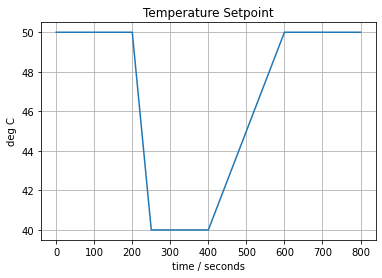

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Temperature Setpoint
def SP(t):
    tp = [  0,  200,  250,  400,  600]
    Tp = [ 50,   50,   40,   40,   50]
    return np.interp(t, tp, Tp)

t = np.linspace(0, 800, 801)
fig, ax = plt.subplots(1, 1)
ax.plot(t, SP(t))
ax.set_title('Temperature Setpoint')
ax.set_xlabel('time / seconds')
ax.set_ylabel('deg C')
ax.grid(True)

Next we implement a simple relay controller using the Python `yield` statement.

In [2]:
# Relay Control
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

Finally, we put these together to form a control system for the regulation of temperature T1 to the desired setpoint using relay control to manipulate `U1`.

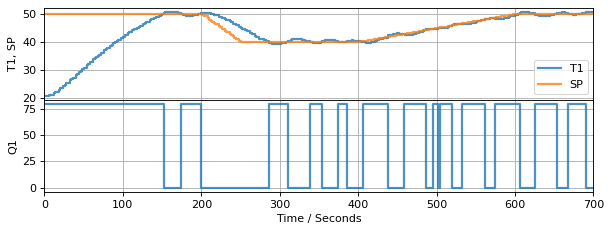

TCLab Model disconnected successfully.


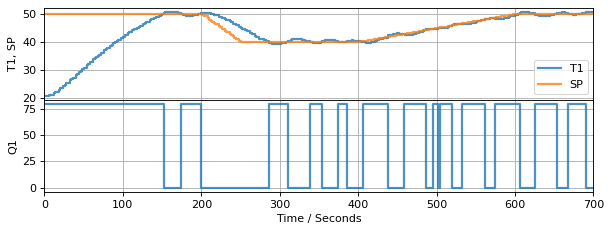

In [3]:
from tclab import setup, clock, Historian, Plotter

# run time
t_final = 700 
t_step = 2

# create a controller instance
controller = relay(MV_min=0, MV_max=80)
U1 = next(controller)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1)])
    p = Plotter(h, t_final, layout=[('T1', 'SP'), ['Q1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1
        U1 = controller.send([SP(t), T1])
        lab.Q1(U1)
        p.update(t) 

## 4.2.2 The Trouble with Output Feedback

So how did we do?

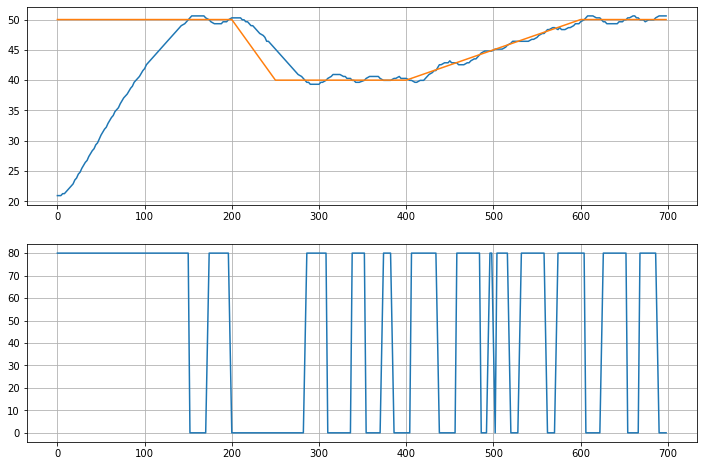

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(h.logdict["Time"], h.logdict["T1"], label="T1")
ax[0].plot(h.logdict["Time"], h.logdict["SP"], label="SP")
ax[0].grid(True)

ax[1].plot(h.logdict["Time"], h.logdict["Q1"], label="Q1")
ax[1].grid(True)

The controller has done a reasonably good job of controlling the sensor temperature. But is that what we're really trying to control?

![](figures/FeedbackControlDiagram2.png)

What if what we actually care about is the heater temperture? How different might the heater temperature be from the sensor temperature?

## 4.2.3 Heater/Sensor Model

This motivates a model

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

where $C^H_p$ and $C^S_p$ are the gross heat capacities of the heater and sensor, respectively, and $U_b$ is a new heat transfer coefficient characterizing the exchange of heat between the heater and sensor.

\begin{align}
\frac{dT_{H,1}}{dt} & = -\frac{U_a+U_b}{C^H_p}T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1}) 
\end{align}

Where measured temperature, that is, the temperature recorded by the Arduino, $T_1$ is given by

$$T_1 = T_{S,1}$$

## 4.2.4 State-Space Model

The same model can be written in a matrix/vector format that we call a **state-space model**:

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \begin{bmatrix} T_H \\ T_S \end{bmatrix}
\qquad
u = \begin{bmatrix} u_1 \end{bmatrix}
\qquad
d = \begin{bmatrix} T_{amb} \end{bmatrix}
\qquad
y = \begin{bmatrix} T_S \end{bmatrix}$$

and

$$A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} \end{bmatrix}
\qquad
B_u = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}
\qquad
B_d = \begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}
\qquad
C = \begin{bmatrix} 0 & 1 \end{bmatrix}$$

Vector $x$ contains all variables representing the **state** of the system.

In [14]:
import numpy as np

# This generate creates a model of the temperature control lab to run in parallel
# with real-time control. This uses the Python 'yield' statement to 
# share data with a calling script.

def tclab():
    # parameter estimates. Modify these to reflect your model fit.
    P =  0.041             # power input when the system is turned
    Ua = 0.065            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Ub = 0.032            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
    Bu = np.array([[P/CpH], [0]])     # single column
    Bd = np.array([[Ua/CpH], [0]])     # single column
    C = np.array([[0, 1]])             # single row

    # initialize variables that will be updated in time
    t_prev = 0
    x = np.array([Tamb, Tamb])
    d = [Tamb]
    
    while True:
        t, Q = yield x   # <= get time and power input, return state
        dt = t - t_prev
        u = [Q]
        x = x + dt*(np.dot(A, x) + np.dot(Bu, u) + np.dot(Bd, d))
        t_prev = t

Let's run the model in parallel with the event loop, feeding both the hardware and model the same information.

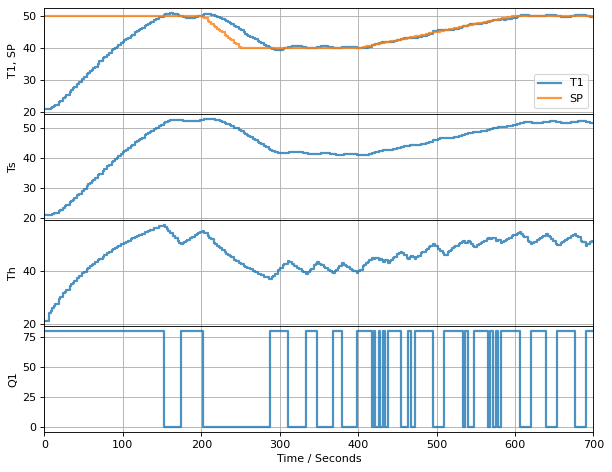

TCLab Model disconnected successfully.


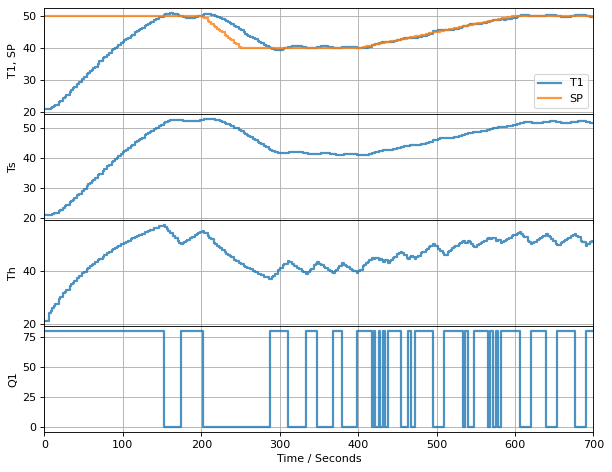

In [15]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

t_final = 700        # run time

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)

# create estimator instance
estimator = tclab()
Th, Ts = next(estimator)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('Th', lambda: Th), ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1', 'SP'], ['Ts'], ['Th'], ['Q1']])
    for t in clock(t_final, 2):
        T1 = lab.T1 
        Th, Ts = estimator.send([t, U1])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP(t), T1])  # <= compute the value of U1 to use for the next time interval
        lab.Q1(U1)
        p.update(t)

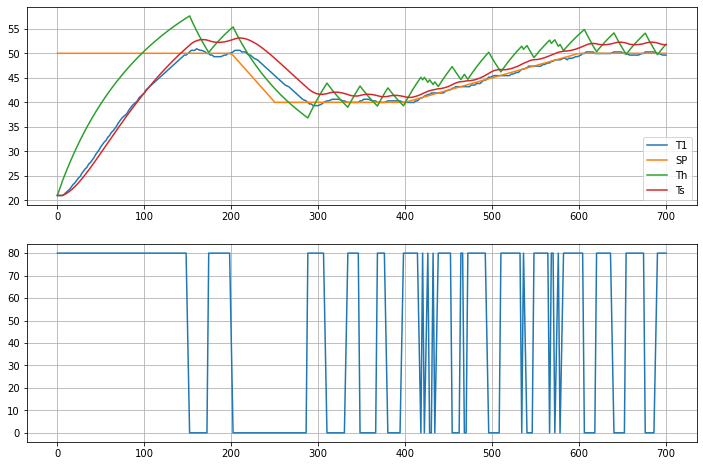

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(h.logdict["Time"], h.logdict["T1"], label="T1")
ax[0].plot(h.logdict["Time"], h.logdict["SP"], label="SP")
ax[0].plot(h.logdict["Time"], h.logdict["Th"], label="Th")
ax[0].plot(h.logdict["Time"], h.logdict["Ts"], label="Ts")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(h.logdict["Time"], h.logdict["Q1"], label="Q1")
ax[1].grid(True)

We see two things:

* We've done a pretty crummy job with controlling heater temperature
* Our model is not perfect since T1 and Ts are different.

In [21]:
## State Estimation

## 4.2.5 Closed-Loop State Estimation and Relay Control

In the second experiment, use a closed loop estimator and relay control to cause the heater to track a desired temperature setpoint. 

Before performing the experiment, you will need to determine suitable values for the observer gain $L$.  $L$ is a matrix consisting of two rows and one column.  You need to choose the values in $L$ such that $A-LC$ is stable and has acceptable time constants. For this experiment we will use a pole placement technique to determine $L$.

\begin{align*}
L & = \begin{bmatrix} ? \\ ? \end{bmatrix}
\end{align*}

**a.**) Before starting the experiment, compute the eigenvalues and corresponding time constants of $A$ and of $A-LC$. 

**b.**) Then repeat the same tasks for Experiment 1, but this time use a closed-loop estimator. In your answers, be sure to describe how the results of this experiment differ from the first, and explain why.

### 4.2.5.1 Review of Closed Loop Estimation

Examining the results, we see the predicted heater temperature appears to track the desired setpoint, but the sensor temperature is off the mark. This could be due several factors, most likely model error.

**Process**
\begin{align*}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align*}

**Model**
\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B_u u + B_d \hat{d}\\
\hat{y} & = C \hat{x}
\end{align*}

If the measured and estimated outputs are different, then $y - \hat{y} \neq 0$. Taking the difference we find

\begin{align*}
y - \hat{y} & = C x - C\hat{x} \\
& = C(x - \hat{x})
\end{align*}

The difference $y - \hat{y}$ can be observed.  But what we want is to make $x - \hat{x}$ small. Is there way to use knowledge of $y - \hat{y}$ to reduce $x - \hat{x}$?

The technique is to introduce feedback $L(y-\hat{y})$ to the model.  

\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B_u u + B_d d + L(y - \hat{y}) \\
\hat{y} & = C \hat{x}
\end{align*}

Subtracting the new model equations from the process model, we get an expression for the dynamics of the model error $e = x - \hat{x}$

\begin{align*}
\frac{de}{dt} & = \frac{dx}{dt} - \frac{d\hat{x}}{dt} \\
\\
& = (Ax + B_u u + B_d d) - (A\hat{x} + B_u u B_d \hat{d} + L(Cx - C\hat{x})) \\
\\
& = (A - LC)(x -\hat{x}) + B_d(d - \hat{d}) \\
\\
\frac{de}{dt} & = (A - LC) e + B_d(d - \hat{d}) 
\end{align*}

The choice of $L$ determines observer performance.

### 4.2.5.2 Choosing $L$

In [26]:
import numpy as np
from scipy.signal import place_poles

P =  0.041            # power input when the system is turned
Ua = 0.065            # heat transfer coefficient from heater to environment
CpH = 6.50            # heat capacity of the heater (J/deg C)
CpS = 1.25            # heat capacity of the sensor (J/deg C)
Ub = 0.032            # heat transfer coefficient from heater to sensor
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
C = np.array([[0, 1]])  # single row

# get the eigenvalues of A and report time constants
eigenvalues, _ = np.linalg.eig(A)
print('Time constants of A are:', -1.0/np.real(eigenvalues), 'seconds')

# place poles of observer to be at least three time faster than open loop estimator
# L = place_poles(A.T, C.T, 3*eigenvalues).gain_matrix

Time constants of A are: [127.70525662  30.58801261] seconds


In the next cell, choose values for L that cause both time constants of the observer to be smaller than the times constants of A, but keep the component values of L small.  This will require some trial and error.

In [31]:
L = np.array([[2],[2]])

eigenvalues_observer, _ = np.linalg.eig(A - np.dot(L, C))
print('Time constants of A - LC are:', -1.0/np.real(eigenvalues_observer), 'seconds')

Time constants of A - LC are: [24.59798726  0.50003267] seconds


In [32]:
import numpy as np
# The following function implements a state observer

def tclab():
    # parameter estimates. Modify these to reflect your model fit.
    P =  0.041             # power input when the system is turned
    Ua = 0.065            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Ub = 0.032            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # initialize variables that will be updated in time
    t = 0
    x = np.array([0, 0])
    
    # observer gain ... put your values here!
    L = [[0.6], [0.3]]
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        dt = tnext - t
        x = x + dt*np.dot(A, x) + dt*np.dot(B, [Q]) + dt*np.dot(L, [T1-Ts])
        t = tnext

So now let's see how this works.

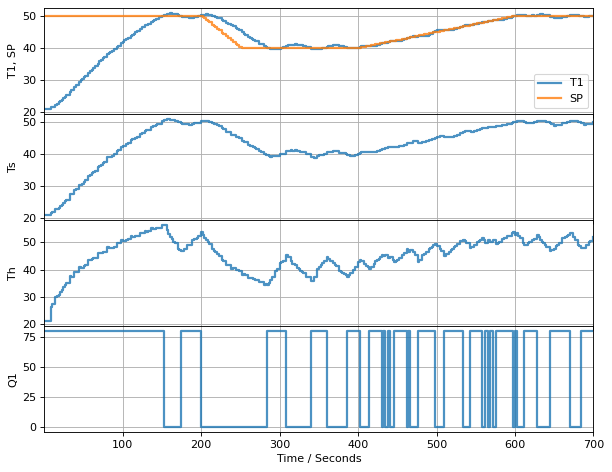

TCLab Model disconnected successfully.


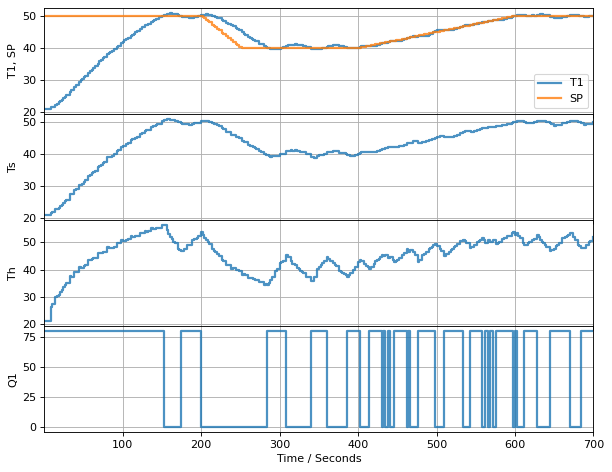

In [33]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

t_final = 700        # run time

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)

# create estimator instance
estimator = tclab()
Th, Ts = next(estimator)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('Th', lambda: Th), ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1', 'SP'], ['Ts'], ['Th'], ['Q1']])
    for t in clock(t_final, 2):
        T1 = lab.T1 
        Th, Ts = estimator.send([t, U1, T1])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP(t), T1])  # <= compute the value of U1 to use for the next time interval
        lab.Q1(U1)
        p.update(t)

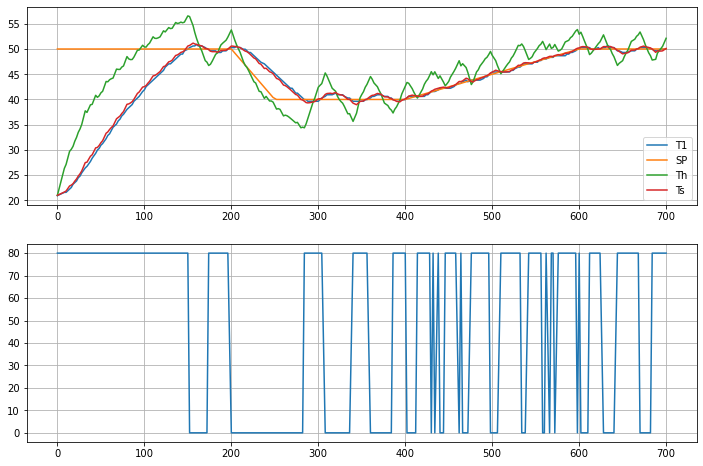

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(h.logdict["Time"], h.logdict["T1"], label="T1")
ax[0].plot(h.logdict["Time"], h.logdict["SP"], label="SP")
ax[0].plot(h.logdict["Time"], h.logdict["Th"], label="Th")
ax[0].plot(h.logdict["Time"], h.logdict["Ts"], label="Ts")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(h.logdict["Time"], h.logdict["Q1"], label="Q1")
ax[1].grid(True)

Zounds!!  We now have an estimator that locks on to the measured value of the sensor temperature.  

Now, if we really trust our model, let's take it a step further, and control the estimated heater temperature.

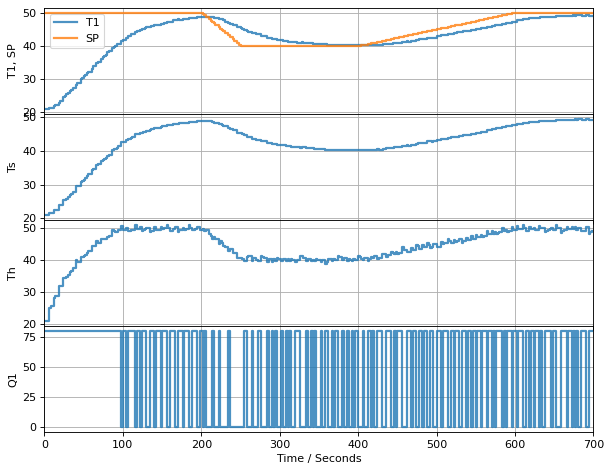

TCLab Model disconnected successfully.


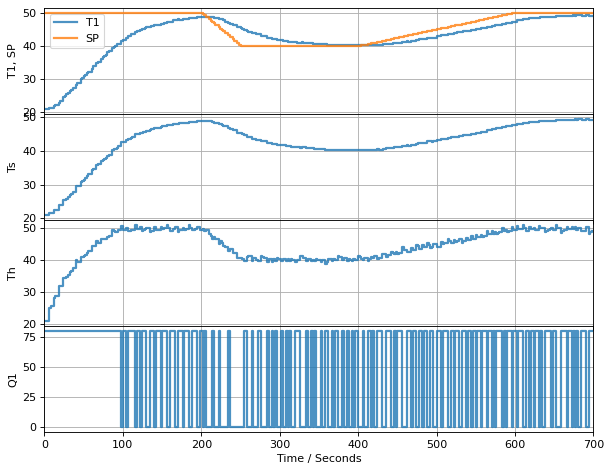

In [35]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

t_final = 700        # run time

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)

# create estimator instance
estimator = tclab()
Th, Ts = next(estimator)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('Th', lambda: Th), ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1', 'SP'], ['Ts'], ['Th'], ['Q1']])
    for t in clock(t_final, 2):
        T1 = lab.T1 
        Th, Ts = estimator.send([t, U1, T1])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP(t), Th])  # <= compute the value of U1 to use for the next time interval
        lab.Q1(U1)
        p.update(t)

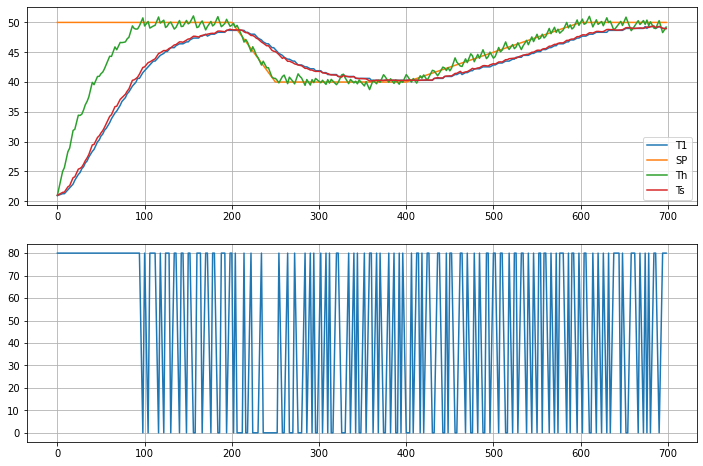

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(h.logdict["Time"], h.logdict["T1"], label="T1")
ax[0].plot(h.logdict["Time"], h.logdict["SP"], label="SP")
ax[0].plot(h.logdict["Time"], h.logdict["Th"], label="Th")
ax[0].plot(h.logdict["Time"], h.logdict["Ts"], label="Ts")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(h.logdict["Time"], h.logdict["Q1"], label="Q1")
ax[1].grid(True)

## 4.2.6 Lab Assignment 5

Step 1. Repeat Exercise 3 from Lab Assignment 2 ... this will give you parameters for a 4 state model of your device.

Step 2. Rewrite the equations for the four state model in state space form.

Step 3. Implement an observer that utilizing measurements T1 and T2, and inputs Q1 and Q2, to estimate the state.

Step 4. Implement relay control for the heater temperatures T1H and T2H using constant setpoints of 45 and 40 degrees, respectively. Compare the performance with and without state estimation.

<!--NAVIGATION-->
< [State Estimation](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/03.00-State-Estimation.ipynb) | [Contents](toc.ipynb) | [Feedback Control](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/04.00-Feedback-Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE32338/blob/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE32338/master/notebooks/03.01-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

<!--NAVIGATION-->
< [4.1 Data/Process/Operational Historian](https://jckantor.github.io/cbe30338-2021/04.01-Process-Historians.html) | [Contents](toc.html) | [4.3 Lab Assignment: State Estimation](https://jckantor.github.io/cbe30338-2021/04.03-Lab-Assigment-State-Estimation.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.02-State-Estimation.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.02-State-Estimation.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>